In [27]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
import rasterio
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

#### Prep the groundwater data

/tmp/ipykernel_644052/77558415.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(resolve_path(config['Groundwater_Productivity_path']), delim_whitespace=True)
Creating geometries: 1019265it [00:06, 161302.20it/s]
Saving file: 100%|██████████| 1019265/1019265 [01:27<00:00, 11590.49it/s]


         X          Y  Liters_Second                  geometry
0  9.41405  37.251192            3.0  POINT (9.41405 37.25119)
1  9.46405  37.251192            3.0  POINT (9.46405 37.25119)
2  9.51405  37.251192            3.0  POINT (9.51405 37.25119)
3  9.56405  37.251192            3.0  POINT (9.56405 37.25119)
4  9.61405  37.251192           22.5  POINT (9.61405 37.25119)


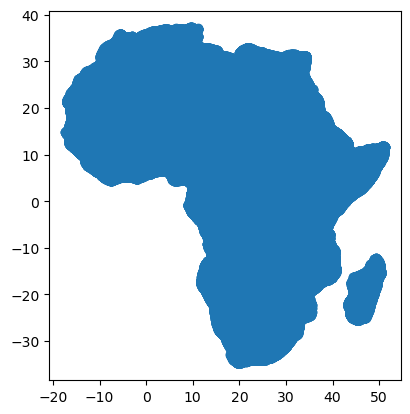

In [28]:
# Enable tqdm for Pandas apply function
tqdm.pandas()

# Load the data with a progress bar
df = pd.read_csv(resolve_path(config['Groundwater_Productivity_path']), sep=r'\s+')

# Create geometry for coordinates with a progress bar
geometry = [Point(xy) for xy in tqdm(zip(df.X, df.Y), desc="Creating geometries")]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

# Rename column 'GWPROD_V2'
gdf.rename(columns={'GWPROD_V2': 'Liters_Second'}, inplace=True)

# Reassign values with a progress bar
value_map = {'VH': 20.0, 'H': 22.5, 'M': 3.0, 'LM': 0.75, 'L': 0.3, 'VL': 0.1}
gdf['Liters_Second'] = gdf['Liters_Second'].progress_apply(lambda x: value_map.get(x, x))

# Save file with a progress bar
with tqdm(total=len(gdf), desc="Saving file") as pbar:
    gdf.to_file(resolve_path(config['Groundwater_Prod_gpkg_path']), layer='groundwater', driver='GPKG')
    pbar.update(len(gdf))

print(gdf.head())
gdf.plot()
plt.show()

#### Filter groundwater productivity to our aridity range

Creating geometries: 1019265it [00:06, 151454.14it/s]
100%|██████████| 1019265/1019265 [00:00<00:00, 1975735.01it/s]


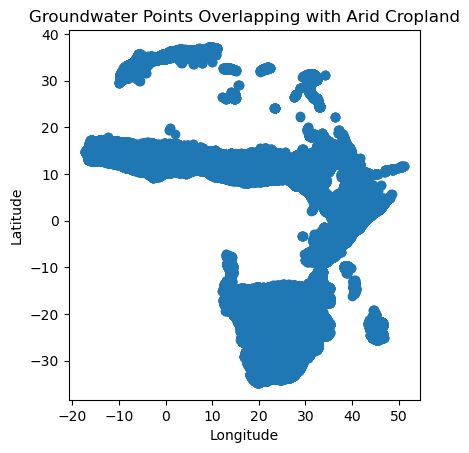

In [34]:
# Enable tqdm for Pandas apply function
tqdm.pandas()

# Load the data with a progress bar
df = pd.read_csv(resolve_path(config['Groundwater_Productivity_path']), sep=r'\s+')

# Create geometry for coordinates with a progress bar
geometry = [Point(xy) for xy in tqdm(zip(df.X, df.Y), desc="Creating geometries")]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

# Rename column 'GWPROD_V2'
gdf.rename(columns={'GWPROD_V2': 'Liters_Second'}, inplace=True)

# Reassign values with a progress bar
value_map = {'VH': 20.0, 'H': 22.5, 'M': 3.0, 'LM': 0.75, 'L': 0.3, 'VL': 0.1}
gdf['Liters_Second'] = gdf['Liters_Second'].progress_apply(lambda x: value_map.get(x, x))

# Load the arid cropland raster data
with rasterio.open(resolve_path(config['Arid_Cropland_tif_path'])) as src:
    cropland_data = src.read(1)
    cropland_transform = src.transform
    cropland_crs = src.crs

# Define a function to check if a point is within cropland
def is_in_cropland(point):
    x, y = point.x, point.y
    col, row = ~cropland_transform * (x, y)
    col, row = int(col), int(row)
    if 0 <= row < cropland_data.shape[0] and 0 <= col < cropland_data.shape[1]:
        return cropland_data[row, col] == 1
    return False

# Apply the function to filter points within cropland
gdf['in_cropland'] = gdf['geometry'].apply(is_in_cropland)
gdf_filtered = gdf[gdf['in_cropland']]

gdf_groundwater = gdf_filtered.to_crs(epsg = 4326)

# Plot the filtered points
gdf_filtered.plot()
plt.title('Groundwater Points Overlapping with Arid Cropland')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Calculate the mean groundwater productivity under CPIS

In [30]:
# Load CPIS data
gdf_CPIS = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))

# Ensure both are in the same CRS
gdf_groundwater = gdf_filtered.to_crs(epsg = 4326)
gdf_CPIS = gdf_CPIS.to_crs(epsg = 4326)

# Perform a spatial join to keep only the points within Combined_CPIS shapes
gdf_filtered_within_CPIS = gpd.sjoin(gdf_filtered, gdf_CPIS, how = 'inner', predicate = 'within', lsuffix = '_left', rsuffix = '_right')

# Calculate mean groundwater productivity for the filtered points within CPIS shapes
mean_groundwater_productivity = gdf_filtered_within_CPIS['Liters_Second'].mean()

print(f"Mean Groundwater Productivity; CPIS: {mean_groundwater_productivity} L/s")

Mean Groundwater Productivity; CPIS: 3.5107913669064748 L/s


#### Calculate the mean groundwater productivity for all cropland

In [31]:
# Load arid cropland data
with rasterio.open(resolve_path(config['Arid_Cropland_tif_path'])) as src:
    masked_cropland_data = src.read(1)
    masked_cropland_transform = src.transform

# Extract groundwater productivity values for cropland areas
groundwater_points = []
for idx, row in gdf_groundwater.iterrows():
    # Get the coordinates of the groundwater point
    x, y = row['X'], row['Y']
    
    # Convert coordinates to raster space
    col_idx, row_idx = ~masked_cropland_transform * (x, y)
    col_idx, row_idx = int(col_idx), int(row_idx)
    
    # Check if the point falls within the cropland area
    if masked_cropland_data[row_idx, col_idx] == 1:
        if not np.isnan(row['Liters_Second']):  # Check if Liters_Second is not NaN
                groundwater_points.append(row['Liters_Second'])

with rasterio.open(resolve_path(config['Africa_Cropland_tif_path'])) as src:
     raw_cropland_data = src.read(1)
     raw_cropland_transform = src.transform

def weighted_mean_groundwater(row):
     x, y = row.geometry.x, row.geometry.y

     # convert coordinates to raster space
     col_idx, row_idx = ~raw_cropland_transform * (x, y)
     col_idx, row_idx = int(col_idx), int(row_idx)

    # Check if the point falls within the raster coverage
     if 0 <= row_idx < raw_cropland_data.shape[0] and 0 <= col_idx < raw_cropland_data.shape[1]:
        weight = raw_cropland_data[row_idx, col_idx]
        if not np.isnan(row['Liters_Second']):  # Check if Liters_Second is not NaN
            return row['Liters_Second'] * weight, weight
     return None, None

# Apply the function to each row in gdf_filtered_within_CPIS
weighted_values = gdf_filtered_within_CPIS.progress_apply(weighted_mean_groundwater, axis=1)

# Separate weighted values and weights, handle None values properly
weighted_values = [(val[0], val[1]) for val in weighted_values if val[0] is not None and val[1] is not None]
weighted_values = [val for val in weighted_values if not np.isnan(val[0]) and not np.isnan(val[1])]

# Check if there are valid values to calculate the mean
if len(weighted_values) > 0:
    weighted_values = np.array(weighted_values)
    weighted_sum = np.sum(weighted_values[:, 0])
    sum_weights = np.sum(weighted_values[:, 1])
    weighted_mean_groundwater_productivity = weighted_sum / sum_weights
    print(f"Weighted Mean Groundwater Productivity: {weighted_mean_groundwater_productivity} L/s")
else:
    print("No valid points found within raster coverage.")

100%|██████████| 279/279 [00:00<00:00, 17467.14it/s]

Weighted Mean Groundwater Productivity: 4.251204658073656 L/s


In [32]:
# Calculate the targeting ratio
targeting_ratio = mean_groundwater_productivity / weighted_mean_groundwater_productivity
print(f"Targeting Ratio: {targeting_ratio}")

Targeting Ratio: 0.825834474997333
